In [9]:
import numpy as np
import matplotlib.pyplot as plt
from axessettings import AxesSetting
import pandas as pd

## active LPF

In [10]:
# H = lambda s: A0*w0**2/(s**+alpha*w0*s+w0**2)
#Z1=Z4=R
#Z2=1/2sC  Z5=1/sC
#Z3=oo
#Rf=0  Rr=oo 
R=1000
C=1e-7
def H(f): 
    s = 2j*np.pi*f
    ret = (1/R/R)/((1/R+2*s*C)*(1/R+s*C)+s*C/R-2*s*C/R)
    return ret
H_gain_theory = lambda f: 20*np.log10(np.abs(H(f)))
H_phase_theory = lambda f: np.angle(H(f), deg=True)

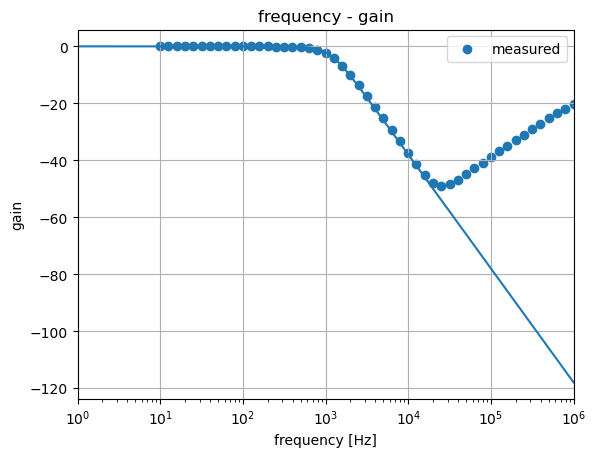

In [11]:
gain_lpf = pd.read_csv("5_bode_activelpf.csv")


fig = plt.figure()
ax = fig.add_subplot(111)
axstg = AxesSetting(legend=True, xlabel="frequency [Hz]", ylabel="gain", grid="both", xlim=(1,1e6),xscale="log", title="frequency - gain")
axstg.plot_func(ax, H_gain_theory)
ax.scatter(gain_lpf["freq"], 20*np.log10(gain_lpf["gain"]), label="measured")
axstg.apply_axes(ax)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


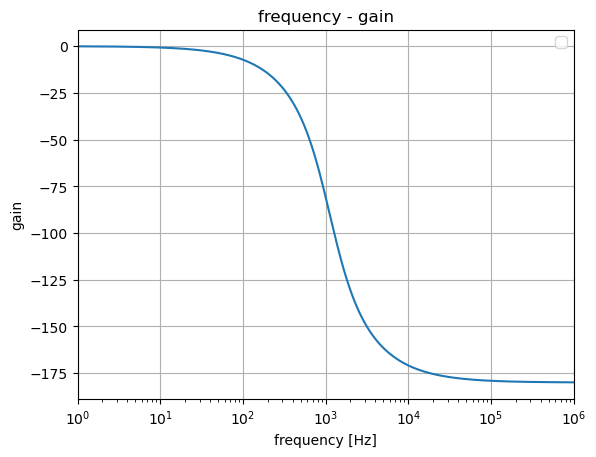

In [12]:

fig = plt.figure()
ax = fig.add_subplot(111)
axstg = AxesSetting(legend=True, xlabel="frequency [Hz]", ylabel="gain", grid="both", xlim=(1,1e6),xscale="log", title="frequency - gain")
axstg.plot_func(ax, H_phase_theory)
# ax.scatter(gain_20["freq"], 20*np.log10(gain_20["phase"]), label="measured")
axstg.apply_axes(ax)

## active HPF

In [13]:
#H = lambda s: ((1+Rf/Rr)/Z1/Z4)/((1/Z1+1/Z2+1/Z3)(1/Z4+1/Z5)+1/Z4/Z5-(1+Rf/Rr)/Z2/Z4)
#Z1=Z4=1/sC
#Z2=R  Z5=2R
#Z3=oo
#Rf=0  Rr=oo
R=10000
C=1e-7
def H(f): 
    s = 2j*np.pi*f
    ret = ((s*C)**2)/((s*C+1/R)*(s*C+1/(2*R))+s*C/(2*R)-s*C/R)
    return ret
H_gain_theory = lambda f: 20*np.log10(np.abs(H(f)))
H_phase_theory = lambda f: np.angle(H(f), deg=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


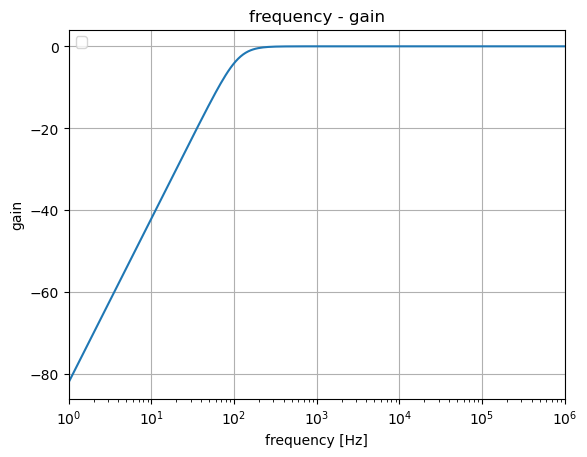

In [14]:
# gain_20 = pd.read_csv("1_bode_invert_1k_10k.csv")


fig = plt.figure()
ax = fig.add_subplot(111)
axstg = AxesSetting(legend=True, xlabel="frequency [Hz]", ylabel="gain", grid="both", xlim=(1,1e6),xscale="log", title="frequency - gain")
axstg.plot_func(ax, H_gain_theory)
# ax.scatter(gain_20["freq"], 20*np.log10(gain_20["gain"]), label="measured")
axstg.apply_axes(ax)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


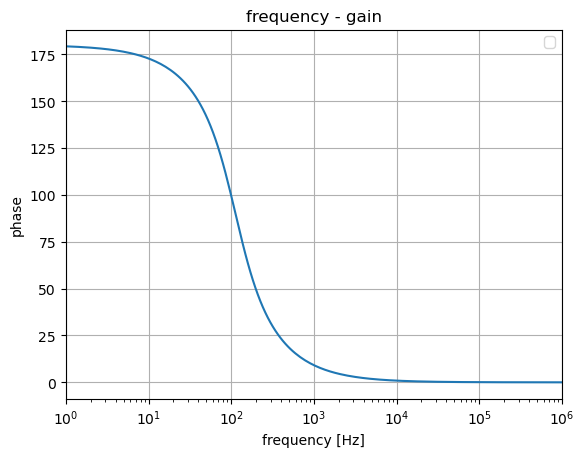

In [15]:

fig = plt.figure()
ax = fig.add_subplot(111)
axstg = AxesSetting(legend=True, xlabel="frequency [Hz]", ylabel="phase", grid="both", xlim=(1,1e6),xscale="log", title="frequency - gain")
axstg.plot_func(ax, H_phase_theory)
# ax.scatter(gain_20["freq"], 20*np.log10(gain_20["phase"]), label="measured")
axstg.apply_axes(ax)